In [5]:
import torch
import torchvision
from models import DeepLabV3
from datasets import gta5dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms as T
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import torch.nn as nn
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import time
import os
from tqdm.notebook import tqdm
from utils import colorize_mask
from PIL import Image


# Data


dataset = gta5dataset("./datas/")
# Data
dataloader = DataLoader(dataset,
                                  shuffle=True,
                                  batch_size=4,
                                  num_workers=0,
                                  pin_memory=False)



device = torch.device("cuda:0")

weight = r"F:\COMP90055\GMIDA\train-runs\2022-09-22_22-44-38\checkpoint\deeplabv3-0.pth"
state_dict = torch.load(weight, map_location=device)
# print(state_dict)
model = DeepLabV3().to(device)      
model.load_state_dict(state_dict)

# output dir
run_time = time.strftime("%Y-%m-%d_%H-%M-%S",time.localtime())
output_dir = "./output/seg"
output_dir = os.path.join(output_dir,run_time)
if os.path.exists(output_dir):
    os.makedir(output_dir)

# visualize
def visualize(im,gt,pred):
    vis_transform = T.Compose([T.ToTensor()])
    plt.imshow(im[0].data.permute(1,2,0).numpy().astype(np.uint8))
    plt.show()
    im = im[0].data.cpu()
    im = np.array(im.permute(1,2,0),dtype=np.uint8)

    im = vis_transform(im)
    
    gt = gt[0].data.cpu().numpy()
    gt = colorize_mask(gt).convert('RGB')
    gt = vis_transform(gt)

    pred = pred[0].data.max(0)[1].cpu().numpy()
    pred = colorize_mask(pred).convert('RGB')
    plt.imshow(pred)
    pred = vis_transform(pred)
    
    grid = torch.stack([im,gt,pred],0)
    grid = make_grid(grid.cpu(), nrow=3, padding=5)
    return grid
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

d:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([4, 3, 128, 256])
tensor(3.) tensor(255.)


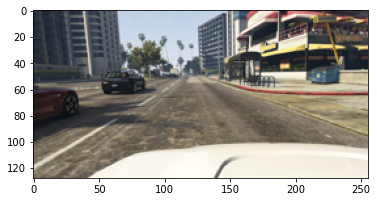

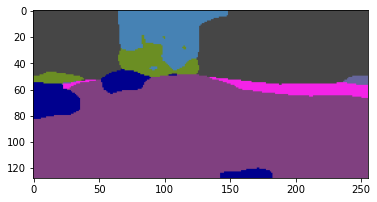

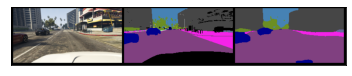

In [6]:
model.eval()
with torch.no_grad():
    for i,(index,image,label) in tqdm(enumerate(dataloader)):
        print(image.size()) # 4 3 128 256
        print(torch.min(image),torch.max(image)) # 0~255
        output = model(image.to(device))['out']

        grid = visualize(image,label,output)
    
        show(grid)
        break